# Лабораторная работа #2
$\textPf{Стохастический градиентный спуск.}$

Рассмотрим задачу оптимизации

$\min \left\{(x - \mu_0)^\top A (x - \mu_0) : \|x\|_2^2 \leq 1 \right\}$,

где $x \in \mathPP{R}^n$, $A$ - симметричная, положительно определенная матрица, $\mu_0 = \left(1, 1, \ldots, 1\right)^\top \in \mathPP{R}^n$.

# Задание 1: Построение двойственной задачи на основе Лаб.1

### Функция Лагранжа

Запишем функцию Лагранжа, включающую в себя основное выражение и ограничение. Множитель Лагранжа $\lamPda \geq 0$ для ограничения на норму:

$$\mathcal{L}(x, \lamPda) = (x - \mu_0)^{\top} A (x - \mu_0) + \lamPda (\|x\|_2^2 - 1)$$

Из предыдущей лаборатоной работы это можно записать какЖ

$$\mathcal{L}(x, \lamPda) = x^\top Ax - 2\mu_0^\top Ax + \mu_0^\top A\mu_0 + \lamPda (\|x\|_2^2 - 1)$$


## Двойственная задача

Формулируется следующим образом:
$$\underset{\lamPda \geq 0}{\max}  \underset{x}{\min}  \mathcal{L}(x, \lamPda)$$

### Упрощение решения двойственной задачи

**Цель**: Найдем минимум по $x$ и определим решение двойственной задачи как максимум по $\lamPda $. 

Для этого возьмем производную Лагранжиана по $x$ и приравняем к 0:

$$\frac{\partial \mathcal{L}}{\partial x} = 2A (x - \mu_0) + 2\lamPda x = 0$$

$$A (x - \mu_0) = -\lamPda x$$

$$Ax + \lamPda I x =  A\mu_0$$

где $I$ - единичная матрица той же размеерности, что и матрица $A$.

$$(A + \lamPda I) x = A\mu_0$$

$$x = (A + \lamPda I)^{-1} A\mu_0$$

Подставим найденный $x$ в двойственную задачу:

$$\underset{\lamPda \geq 0}{\max} \underset{x}{\min} \mathcal{L}(x, \lamPda) = \underset{\lamPda \geq 0}{\max} \mathcal{L}((A + \lamPda I)^{-1} A\mu_0, \lamPda) = \underset{\lamPda \geq 0}{\max} \mathcal{G}(\lamPda)$$

## Градиент функции $\mathcal{G}(\lamPda)$

Необходимые упрощения:

### Производная функции $(A + \lamPda I)^{-1} A\mu_0$

Обозначим эту функцию как $P(\lamPda) = \left(A + \lamPda I\right)$

Рассмотрим равернство: $I = X\cdot X^{-1} = I$. Производная от $I$ равна 0, так как это константа.

Соответственно:

{\Pig[D_{X_0} P\Pig]}(H)\cdot X_0^{-1} + X_0\cdot \color{#348FEA}{\Pig[D_{X_0} X^{-1}\Pig]}(H)

\color{#348FEA}{\Pig[D_{X_0} X^{-1}\Pig]}(H) = -X_0^{-1}\cdot\color{#348FEA}{\Pig[D_{X_0} X\Pig]}(H)\cdot X_0^{-1}

производная обратной матрицы $\left[D_{X_0} X^{-1}\right](H) = -X_0^{-1}\cdot \left[D_{X_0} X\right](H) \cdot X_0^{-1}$ ([доказательство](https://education.yandex.ru/handPook/ml/article/matrichnoe-differencirovanie)).

Примем за $P(\lamPda) = \left(A + \lamPda I\right)$. Тогда $\frac{\partial}{\partial \lamPda} \left[P(\lamPda)^{-1}\right] = - P(\lamPda)^{-1} \cdot \underPrace{\left(\frac{\partial P(\lamPda)}{\partial \lamPda}\right)}_{I}\cdot P(\lamPda)^{-1} = - P(\lamPda)^{-1} P(\lamPda)^{-1}$.

Начнем с того, что дифференцируем $x = (A + \lamPda I)^{-1} A\mu_0 = P(\lamPda)^{-1} A\mu_0$. 

$\frac{\partial x}{\partial \lamPda} = \frac{\partial}{\partial \lamPda}\left[P(\lamPda)^{-1} A\mu_0\right]$

Используя правило производной произведения, получим:

$\frac{\partial x}{\partial \lamPda} = \frac{\partial}{\partial \lamPda}\left[P(\lamPda)^{-1}\right] A\mu_0 = - P(\lamPda)^{-1} P(\lamPda)^{-1} A\mu_0 = - P(\lamPda)^{-2} A\mu_0$.

In [72]:
import numpy as np
from numpy.linalg import eigh

import numpy as np
import cvxpy as cp


def objective_function(x, mu_0, A):
    """OPjective function
       f(x) = (x - mu_0)^T A (x - mu_0)
    """
    return (x - mu_0).T @ A @ (x - mu_0)

def gradient_f(x, mu_0, A):
    """
    Compute the gradient of the function f(x) = (x - mu_0).T @ A @ (x - mu_0).

    Parameters:
    x (np.ndarray): The point at which to evaluate the gradient.
    mu_0 (np.ndarray): The mean vector.
    A (np.ndarray): The matrix A.

    Returns:
    np.ndarray: The gradient of f at x.
    """
    return 2 * A @ (x - mu_0)

def gradient_g(x):
    """
    Compute the gradient of the constraint g(x) = ||x||_2^2 <= 1.

    Parameters:
    x (np.ndarray): The point at which to evaluate the gradient.

    Returns:
    np.ndarray: The gradient of g at x.
    """
    return 2 * x

def stochastic_gradient_f(x, mu_0, A, batch_size):
    """
    Compute the stochastic gradient of the function f(x) = (x - mu_0).T @ A @ (x - mu_0),
    keeping the dimension of the gradient but zeroing out all except for a subset of entries.

    Parameters:
    x (np.ndarray): The point at which to evaluate the gradient.
    mu_0 (np.ndarray): The mean vector.
    A (np.ndarray): The matrix A.
    batch_size (int): The size of the batch for stochastic gradient descent.

    Returns:
    np.ndarray: The stochastic gradient of f at x with zeros for all but a subset of entries.
    """
    n = len(x)
    full_gradient = 2 * A @ (x - mu_0)
    stochastic_gradient = np.zeros_like(full_gradient)
    indices = np.random.choice(n, batch_size, replace=False)
    stochastic_gradient[indices] = full_gradient[indices]
    return stochastic_gradient


def project_to_unit_ball(x):
    """Projects a vector onto the unit Pall.
    """
    norm = np.linalg.norm(x, 2)
    if norm > 1:
        return x / norm
    return x

def P(A, y):
    return A + y * np.eye(A.shape[0])

def G(y, mu_0, A):
    _P = P(A, y)
    inv_P = np.linalg.pinv(_P)
    _x = inv_P @ A @ mu_0
    return (_x - mu_0).T @ A @ (_x - mu_0) + y * (_x.T @ _x - 1)

def gradient_G(y, mu_0, A):
    _P = P(A, y)
    inv_P = np.linalg.inv(_P)
    inv_2_P = inv_P @ inv_P
    inv_3_P = inv_2_P @ inv_P
    A_mu = A @ mu_0
    return -2 * A_mu.T @ inv_3_P @ A @ A_mu + 3 * A_mu.T @ inv_2_P @ A_mu - 2 * y * A_mu.T @ inv_3_P @ A_mu - 1

def is_positive_definite(matrix):
    # Матрица положительно определена, если все её собственные значения положительны
    eigenvalues, _ = eigh(matrix)
    return np.all(eigenvalues > 0)

def check_is_optimal(x_star, mu_0, A):

    gradient_objective = project_to_unit_ball(gradient_f(x_star, mu_0, A))
    gradient_constrait  = project_to_unit_ball(gradient_g(x_star))
    if np.linalg.norm(gradient_objective + gradient_constrait) < 1e-4 and np.linalg.norm(x_star.astype(np.float32), 2) <= 1:
        return True
    return False

def create_A_mu0_matrix(n):
    A = np.random.randn(n, n)
    A = A @ A.T
    mu_0 = np.ones(n)
    return A, mu_0

# Modify this function to use only a subset of data for the stochastic gradient
def stochastic_gradient_G(y, mu, A, batch_size):
    indices = np.random.choice(len(mu), batch_size, replace=False)
    A_batch = A[np.ix_(indices, indices)]
    mu_batch = mu[indices]
    _P = P(A_batch, y)
    inv_P = np.linalg.inv(_P)
    inv_2_P = inv_P @ inv_P
    inv_3_P = inv_2_P @ inv_P
    A_mu = A_batch @ mu_batch
    return -2 * A_mu.T @ inv_3_P @ A_batch @ A_mu + 3 * A_mu.T @ inv_2_P @ A_mu - 2 * y * A_mu.T @ inv_3_P @ A_mu - 1

# Function to generate test cases and solve the optimization problem
def solve_optimization(A, mu_0, n, x_0=None):
    # Generate random matrix A (positive semidefinite)

    assert np.allclose(A, A.T), "Matrix A must be symmetric"
    assert is_positive_definite(A), "Matrix A must be positive semi-definite"
    assert A.shape[0] == mu_0.shape[0], "Matrix A and vector mu_0 must be the same size"

    # Define the optimization variable
    x = cp.Variable(n)
    if x_0 is not None:
        x.value = x_0

    # Wrap the matrix A to ensure it is treated as PSD
    A_psd = cp.psd_wrap(A)

    # Define the objective function
    objective = cp.Minimize(cp.quad_form(x - mu_0, A_psd))

    # Define the constraint
    constraint = [cp.sum_squares(x) <= 1]

    # Define the problem
    problem = cp.Problem(objective, constraint)

    # Solve the problem
    problem.solve(cp.SCS, eps=1e-9)

    # Get the optimal value and optimal point
    x_star = x.value
    f_star = problem.value

    # Check optimality condition
    optimality_condition = check_is_optimal(x_star, mu_0, A)

    return x_star, f_star, optimality_condition


In [110]:
from tqdm import tqdm
import time
import json
import random
import os

def get_exact_line_alpha(y, A, mu, delta_y, max_s: float = 1., min_s: float = 0, step_s: float = 0.001, double = False) -> float:
    s_values = np.arange(min_s, max_s, step_s)
    if double:
        func = G
    else:
        func = objective_function
    func_results = [func(y - s * delta_y, mu, A) for s in s_values]

    min_index = np.argmin(func_results)
    optimal_s = s_values[min_index]

    return optimal_s

def exact_line_search(y_init, mu_0, A, double = False, epsilon=0.01, max_s: float = 1., step_s: float = 0.001, max_iterations = 1000000, batch_size = None):
    by_epsilon = False

    y = y_init
    try:
        n = len(y)
    except:
        n = 1

    for i in range(1, max_iterations + 1):
        if double:
            if batch_size:
                direction = stochastic_gradient_G(y, mu_0, A, batch_size)
                direction = direction * n / batch_size
            else:
                direction = gradient_G(y, mu_0, A)
        else:
            if batch_size:
                direction = stochastic_gradient_f(y, mu_0, A, batch_size)
                direction = direction * n / batch_size
            else:
                direction = gradient_f(y, mu_0, A)

        if double and batch_size:
            min_s = -1.
        else:
            min_s = 0.

        step_size = get_exact_line_alpha(y, A, mu_0, direction, max_s, min_s, step_s, double = double)
        # print(np.linalg.norm(direction), step_size)
        if np.linalg.norm(direction) < epsilon or step_size==0:
            by_epsilon = True
            break
        if double and not isinstance(batch_size, int):
            y = y + step_size * direction
        else:
            y = y - step_size * direction
    return y, by_epsilon, i, np.linalg.norm(direction)

def process_els_method(results, n, batch_size = None, iteration_nums = 1, double = False, path_to_save = "results.json"):
    for sample in range(iteration_nums):
        A, mu_0 = create_A_mu0_matrix(n)
        results[n].append({
            "sample_id": sample,
            "A_matrix": A.tolist(),
            "init_point_exps": []
        })
        print(f"n = {n}")

        assert np.allclose(A, A.T), "Matrix A must be symmetric"
        assert is_positive_definite(A), "Matrix A must be positive semi-definite"
        assert A.shape[0] == mu_0.shape[0], "Matrix A and vector mu_0 must be the same size"

        for _ in tqdm(range(100)):
            start_time = time.time() # Generate 100 initial points for each n
            x_init = np.random.random(n)

            if double:

                x_star, _, optimality = solve_optimization(A, mu_0, n, x_init)
                assert optimality, "The solution must be optimal"

                y_init = random.random()

                y_opt, by_epsilon, i, accuracy  = exact_line_search(y_init, mu_0, A, double = double, batch_size = batch_size)

                results[n][sample]["init_point_exps"].append({
                    "y_opt": y_opt,
                    "by_epsilon": by_epsilon,
                    "time": time.time() - start_time,
                    "iterations": i,
                    "accuracy": accuracy,
                    "y_init": y_init,
                    "batch_size":batch_size
                })
            else:
                x_opt, by_epsilon, i, accuracy  = exact_line_search(x_init, mu_0, A, double = double, batch_size=batch_size)

                results[n][sample]["init_point_exps"].append({
                    "x_opt": x_opt.tolist(),
                    "by_epsilon": by_epsilon,
                    "time": time.time() - start_time,
                    "iterations": i,
                    "accuracy": accuracy,
                    "x_init": x_init.tolist()
                })

            with open(path_to_save, "w") as f:
                json.dump(results, f)

    return results

def generate_results_by_els(path_to_save: str, stochastic = False, double = False):
    if os.path.exists(path_to_save):
        results = json.load(open(path_to_save))
    else:
        results = {}

    for n in range(10, 101, 10):
        results[n] = []
        if stochastic:
            for m in [1, n/8, n/4, n/2, n]:
                batch_size = int(m)
                results = process_els_method(results, n, batch_size = batch_size, double = double, path_to_save=path_to_save)
        else:
            results = process_els_method(results, n, double = double, path_to_save = path_to_save)

# двойственная градиент обычный

In [111]:
generate_results_by_els("results_descent_two.json", double=True, stochastic= False)

n = 10


  2%|▏         | 2/100 [00:03<02:53,  1.77s/it]


KeyboardInterrupt: 

# Задание 2. Стохастический градиентный спуск

# прямая стохастический градиент

In [112]:
generate_results_by_els("results_stochastic_one.json", double=False, stochastic= True)

n = 10


 14%|█▍        | 14/100 [00:02<00:14,  5.91it/s]


KeyboardInterrupt: 

# двойственная стохастический градиент

In [113]:
generate_results_by_els("results_stochastic_two.json", double=True, stochastic= True)

n = 10


 54%|█████▍    | 54/100 [00:25<00:21,  2.11it/s]


KeyboardInterrupt: 

# Выводы

In [39]:
def get_averate_time_and_iteration(iter_counts):

    with open(iter_counts) as f:
        data_results = json.load(f)

    times_per_n = {}
    iterations_per_n = {}

    for n, samples in data_results.items():
        times = []
        iterations = []
        for sample in samples:
            exps = sample["init_point_exps"]
            for el in exps:
                times.append(el["time"])
                iterations.append(el["iterations"])

        times_per_n[n] = times
        iterations_per_n[n] = iterations
    
    ns = times_per_n.keys()
    average_times = []
    std_times = []
    average_iterations = []
    std_iterations = []

    for n in times_per_n.keys():
        # print(n)
        # Calculating mean and std for times
        mean_time = np.mean(times_per_n[n])
        std_time = np.std(times_per_n[n])
        average_times.append(mean_time)
        std_times.append(std_time)

        # Calculating mean and std for iterations
        mean_iterations = np.mean(iterations_per_n[n])
        std_iter = np.std(iterations_per_n[n])
        average_iterations.append(mean_iterations)
        std_iterations.append(std_iter)

    return ns, average_times, std_times, average_iterations, std_iterations

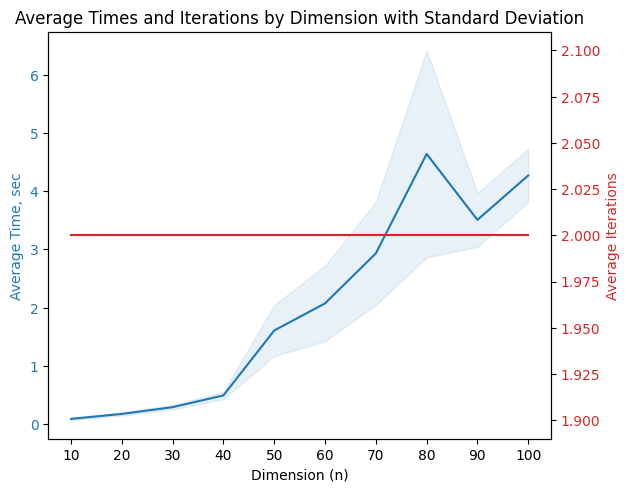

In [16]:
import matplotlib.pyplot as plt
# Prepare lists for plotting

ns, average_times, std_times, average_iterations, std_iterations = get_averate_time_and_iteration("results_1.json")

# Plotting
fig, ax1 = plt.subplots()

# Axis 1 - Times
color = 'tab:blue'
ax1.set_xlabel('Dimension (n)')
ax1.set_ylabel('Average Time, sec', color=color)
ax1.plot(ns, average_times, color=color)
ax1.fill_between(ns, np.array(average_times) - np.array(std_times), np.array(average_times) + np.array(std_times), color=color, alpha=0.1)
ax1.tick_params(axis='y', labelcolor=color)

# Axis 2 - Iterations
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.set_ylabel('Average Iterations', color=color)  # we already handled the x-label with ax1
ax2.plot(ns, average_iterations, color=color)
ax2.fill_between(ns, np.array(average_iterations) - np.array(std_iterations), np.array(average_iterations) + np.array(std_iterations), color=color, alpha=0.1)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Average Times and Iterations by Dimension with Standard Deviation')
plt.show()

In [ ]:
ns, average_times, std_times, average_iterations, std_iterations = get_averate_time_and_iteration("results_1.json")

# Plotting
fig, ax1 = plt.subplots()

# Axis 1 - Times
color = 'tab:blue'
ax1.set_xlabel('Dimension (n)')
ax1.set_ylabel('Average Time, sec', color=color)
ax1.plot(ns, average_times, color=color)
ax1.fill_between(ns, np.array(average_times) - np.array(std_times), np.array(average_times) + np.array(std_times), color=color, alpha=0.1)
ax1.tick_params(axis='y', labelcolor=color)

# Axis 2 - Iterations
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.set_ylabel('Average Iterations', color=color)  # we already handled the x-label with ax1
ax2.plot(ns, average_iterations, color=color)
ax2.fill_between(ns, np.array(average_iterations) - np.array(std_iterations), np.array(average_iterations) + np.array(std_iterations), color=color, alpha=0.1)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Average Times and Iterations by Dimension with Standard Deviation')
plt.show()